In [1]:
load_cached_file = True # if True, vectorize_subset is ignored
vectorize_subset = 100 # for quicker testing, only vectorize a subset of documents. Otherwise, set to -1 to process all 22,000 (takes about 6 hours)

In [2]:
from scipy.spatial.distance import cdist
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from ipywidgets import interact, widgets # this is what makes the dataframe interactive

# BioBERT dependencies
# Tensorflow 2.0 didn't work with the pretrained BioBERT weights
# !pip install tensorflow==1.15
# Install bert-as-service
# !pip install bert-serving-server==1.10.0
# !pip install bert-serving-client==1.10.0

# CorEx topic modeling dependencies
# https://github.com/gregversteeg/corex_topic
# !pip install 'corextopic'
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as ss
from corextopic import corextopic as ct

/anaconda/envs/py37_tensorflow115/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
if load_cached_file is True:
    df = pkl.load(open('df_biobert_vectors.pkl', "rb"))
    unvectorized_df = pkl.load(open('df_final_covid_clean_topics.pkl', "rb"))
    df['clean_tfidf'] = unvectorized_df['clean_tfidf'] # copy over the heavily preprocessed and already tokenized words for CorEx
else:
    df = pkl.load(open('df_final_covid_clean_topics.pkl', "rb"))
    df = df.reset_index() # just in case the indices aren't sequential

0: domain,residue,binding,sequence,structure,structural,rna,amino_acid,genome,mutation
1: pathway,cellular,mechanism,signal,function,role,regulate,host,mrna,intracellular
2: health,international,national,country,policy,practice,public,service,government,healthcare
3: response,ifn,mouse,cytokine,immune_response,immune,inflammatory,inflammation,interferon,macrophage
4: expression,replication,inhibit,receptor,express,activity,vitro,activation,induced,inhibition
5: public_health,research,infectious_disease,approach,need,future,threat,new,information,global
6: sample,detection,detect,pcr,test,positive,specimen,diagnostic,rtpcr,polymerase_chain_reaction
7: severe_acute_respiratory,respiratory,syndrome_coronavirus,middle_east_respiratory,sarscov,patient,merscov,syndrome_sars,sars,coronavirus
8: hospital,risk,conduct,estimate,care,participant,measure,confidence_interval,questionnaire,enrol
9: lung,acute,clinical,day,pulmonary,severe,associate,treatment,outcome,severity
10: conclusion,backgroun

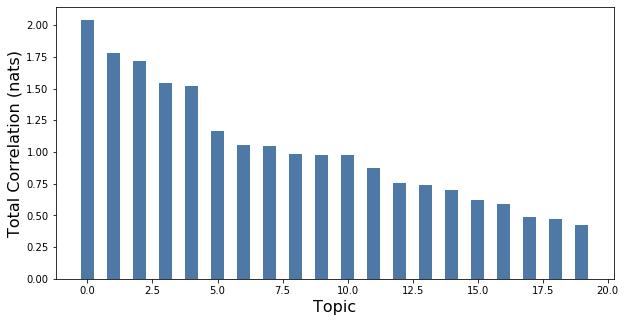

In [4]:
%%time

# takes 20-60 seconds depending on how many CorEx topics you select

target_num_topics = 20 # num topics CorEx will identify

def dummy(doc):
    return doc

vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
)

# to process without my cached file, you can comment out the dummy params in CountVectorizer and change this line to use df['document'].
# NOTE: this will greatly increase the run time of this cell.
corex_docs = df['clean_tfidf'].tolist()
doc_word = vectorizer.fit_transform(corex_docs)

doc_word = ss.csr_matrix(doc_word)

# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

# https://github.com/gregversteeg/corex_topic
# Train the CorEx topic model with x topics (n_hidden)
topic_model = ct.Corex(n_hidden=target_num_topics, words=words, max_iter=1000, verbose=False, seed=2020)

# You can seed CorEx with anchor words for some topics if you find it is struggling in certain areas
# domain expertise is important to choose the right anchor words
#topic_model.fit(doc_word, words=words, anchors=[
#    ['transmission', 'incubation'],
#    ['bat', 'pig', 'porcine'],
#    ['national','international','policy', 'public_health', 'public']
#], anchor_strength=2)

# or use the default where it is unguided
topic_model.fit(doc_word, words=words)

# plot overall topic scores
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
# no single topic should contribute too much. If one does, that indicates more investigation for boilerplate text, more preprocessing required
# To find optimal num of topics, we should keep adding topics until additional topics do not significantly contribute to the overall TC

topics = topic_model.get_topics()
topic_list = []

for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))
    topic_list.append('topic_' + str(n) + ': ' + ', '.join(topic_words))

In [5]:
# Train successive hierarchical layers
tm_layer2 = ct.Corex(n_hidden=4)
tm_layer2.fit(topic_model.labels)

layer2_topics = tm_layer2.get_topics()
parents = []

for parent_topic in layer2_topics:
    layer_obj = {
        'keys': [],
        'words': []
    }
    
    for ind, _ in parent_topic:
        layer_obj['keys'] += [ind]
        layer_obj['words'] += [w[0] for w in topics[ind]][0:3]
    
    parents.append(layer_obj)

print('\n')

for p_topic in parents:
    key_str = [str(k) for k in p_topic['keys']]
    keys = ','.join(key_str)
    top_words = ','.join(p_topic['words'])
    
    print('PARENT GROUP: ' + keys)
    print(top_words + '\n')

NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices


PARENT GROUP: 4,1,15,8,2,0,18,3,6,13
expression,replication,inhibit,pathway,cellular,mechanism,gene,outbreak,functional,hospital,risk,conduct,health,international,national,domain,residue,binding,case,china,december,response,ifn,mouse,sample,detection,detect,vaccine,efficacy,development

PARENT GROUP: 7
severe_acute_respiratory,respiratory,syndrome_coronavirus

PARENT GROUP: 5,17,14,11,12
public_health,research,infectious_disease,review,indicate,suggest,tool,base,apply,antibody,serum,pig,specie,bat,evolution

PARENT GROUP: 10,16,9,19
conclusion,background,objective,age,year,electronic_supplementary_material_online,lung,acute,clinical,bacteria,bacterial,antibiotic



In [6]:
# remove any existing topic columns from previous runs
for c in [col for col in df.columns if col.startswith('topic_')]:
    del df[c]

for topic_num in range(0, len(topics)):
    # CorEx stores the likelihood scores in the same order as the source document, so the index will match
    df['topic_' + str(topic_num)] = topic_model.log_p_y_given_x[:,topic_num]

# For display purposes, create a final "best_topic" column which is the highest scoring topic for a row.
# The search UI will allow you to optionally view all topic scores
corex_cols = [col for col in df if col.startswith('topic_')]
df['best_topic'] = df[corex_cols].idxmax(axis=1)

In [10]:
%%time
# takes 20 sec to start the BERT server

# the documentation recommends batch size of 16 for CPU, 256 for GPU
# Kaggle notebooks have 2 cpus, which is the num_worker param

# bert_command = 'bert-serving-start -model_dir biobert_v1.1_pubmed -max_seq_len=None -max_batch_size=32 -num_worker=4'
# bert_command = 'bert-serving-start -model_dir biobert_large/biobert_large -max_seq_len=None -max_batch_size=32 -num_worker=4'
# process = subprocess.Popen(bert_command.split(), stdout=subprocess.PIPE)

# Start the BERT client. It takes about 10 seconds for the bert server to start, which delays the client
from bert_serving.client import BertClient

bc = BertClient()

CPU times: user 2 ms, sys: 89 µs, total: 2.09 ms
Wall time: 102 ms


In [11]:
%%time

if load_cached_file is False:
    # FOR TESTING - shuffle rows and select n
    if (vectorize_subset > -1):
        df = df.sample(frac=1).head(vectorize_subset).reset_index(drop=True)

    abstracts = df['document'].tolist()

    # add the BioBERT vector to each row
    embeddings = bc.encode(abstracts)

    select_cols = ['title', 'abstract', 'authors', 'document', 'clean_tfidf']

    # slim down filesize of dataframe by only selecting the cols we need
    df = df[select_cols]

    df['biobert_vector'] = embeddings.tolist()
    pkl.dump(df, open('df_biobert_vectors.pkl', "wb"))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [12]:
print('To focus on a CorEx topic area, select it from the dropdown and drag the threshold slider to the right.')
print('A higher threshold value will filter out results that are less likely to be belong to the topic.')

default_question = """What is known about transmission, incubation, and environmental stability? """

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_colwidth', 120)

biobert_vectors = np.array(df.biobert_vector.tolist())
total_docs = len(df.index)

@interact
def search_articles(
    query=default_question,
    topic=topic_list,
    #topic_threshold=(-20, 0.00, 0.5),
    topic_threshold=widgets.IntSlider(min=-15,max=0,step=0.5,value=-15),
    num_results=[10, 25, 100],
    show_topic_scores=[False, True],
    score_type=['cosine', 'Euclidean'],
    
):

    query_embedding = bc.encode([query])[0]

    sort_ascending = False
    score = []
    
    if score_type is 'Euclidean':
        score = np.sum(query_embedding * biobert_vectors, axis=1) / np.linalg.norm(biobert_vectors, axis=1)
        sort_ascending = False
    else:
#         print(len(np.stack(df.biobert_vector)), len(query_embedding), query_embedding)
        score = cdist(np.stack(df.biobert_vector), [query_embedding], metric="cosine")
#         score = 0
        sort_ascending = True
    
    df["score"] = score
    
    # smaller corex_topic scores means more likely to be of that topic
    corex_cols = []
    if show_topic_scores is True:
        corex_cols = [col for col in df if col.startswith('topic_')]
        
    select_cols = ['title', 'abstract', 'authors', 'score', 'best_topic'] + corex_cols
    
    results = df[select_cols].loc[df[topic.split(':')[0]] > topic_threshold].sort_values(by=['score'], ascending=sort_ascending).head(num_results)
    
    if (len(results.index) == 0):
        print('NO RESULTS')
        
        return None
    else:

        top_row = results.iloc[0]

        print('TOP RESULT OUT OF ' + str(total_docs) + ' DOCS FOR QUESTION:\n' + query + '\n')
        print('TITLE: ' + top_row['title'] + '\n')
        print('ABSTRACT: ' + top_row['abstract'] + '\n')
        print('PREDICTED TOPIC: ' + topic_list[int(top_row['best_topic'].replace('topic_', ''))])

        print('\nAUTHORS: ' + str(top_row['authors']))

        select_cols.remove('authors')
        
        return results[select_cols]

To focus on a CorEx topic area, select it from the dropdown and drag the threshold slider to the right.
A higher threshold value will filter out results that are less likely to be belong to the topic.


interactive(children=(Text(value='What is known about transmission, incubation, and environmental stability? '…